(media_saturation)=
# Understanding Media Saturation in Marketing Mix Models

One of the most important concepts in Marketing Mix Modeling (MMM) is **media saturation** - the phenomenon where the incremental impact of advertising spend diminishes as spending increases. Understanding saturation is crucial for making optimal budget allocation decisions.

This tutorial explores two complementary ways to visualize and understand media saturation:

1. **Direct/Marginal Contribution** (`saturation_scatterplot`) - Shows the relationship between spend and contribution at each time point
2. **Total Contribution over Spend Share** (`plot_channel_contribution_grid`) - Shows how total contribution changes as you scale overall spend

```{warning}
These two visualizations answer different questions and are often confused. This tutorial clarifies the distinction and provides guidance on when to use each.
```

## Setup and Data Preparation

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%config InlineBackend.figure_format = "retina"

# Random seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/multidimensional.py:216: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/time_slice_cross_validation.py:32: UserWarning: The pymc_marketing.mmm.builders module is experimental and its API may change without warning.
  from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml


We use the same simulated data from the {ref}`mmm_multidimensional_example`. This dataset contains sales data for two geographies (`geo_a` and `geo_b`) with two marketing channels (`x1` and `x2`).

In [2]:
data_path = data_dir / "mmm_multidimensional_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date"])
data_df.head(10)

,date,geo,x1,x2,event_1,event_2,y
0,2022-06-06,geo_a,5527.640078,0.000000,0,0,2647.596355
1,2022-06-06,geo_b,8849.257500,8063.918386,0,0,682.406280
2,2022-06-13,geo_a,6692.655692,0.000000,0,0,5020.823907
3,2022-06-13,geo_b,9073.817994,9354.014585,0,0,3753.104897
4,2022-06-20,geo_a,7124.016733,0.000000,0,0,6184.322132
5,2022-06-20,geo_b,7867.854558,5608.112521,0,0,3329.279953
6,2022-06-27,geo_a,7725.169902,0.000000,0,0,5446.374631
7,2022-06-27,geo_b,9712.332359,11760.981800,0,0,7544.192188
8,2022-07-04,geo_a,8545.792935,0.000000,0,0,10058.970814
9,2022-07-04,geo_b,6747.884370,6774.114961,0,0,2359.259385


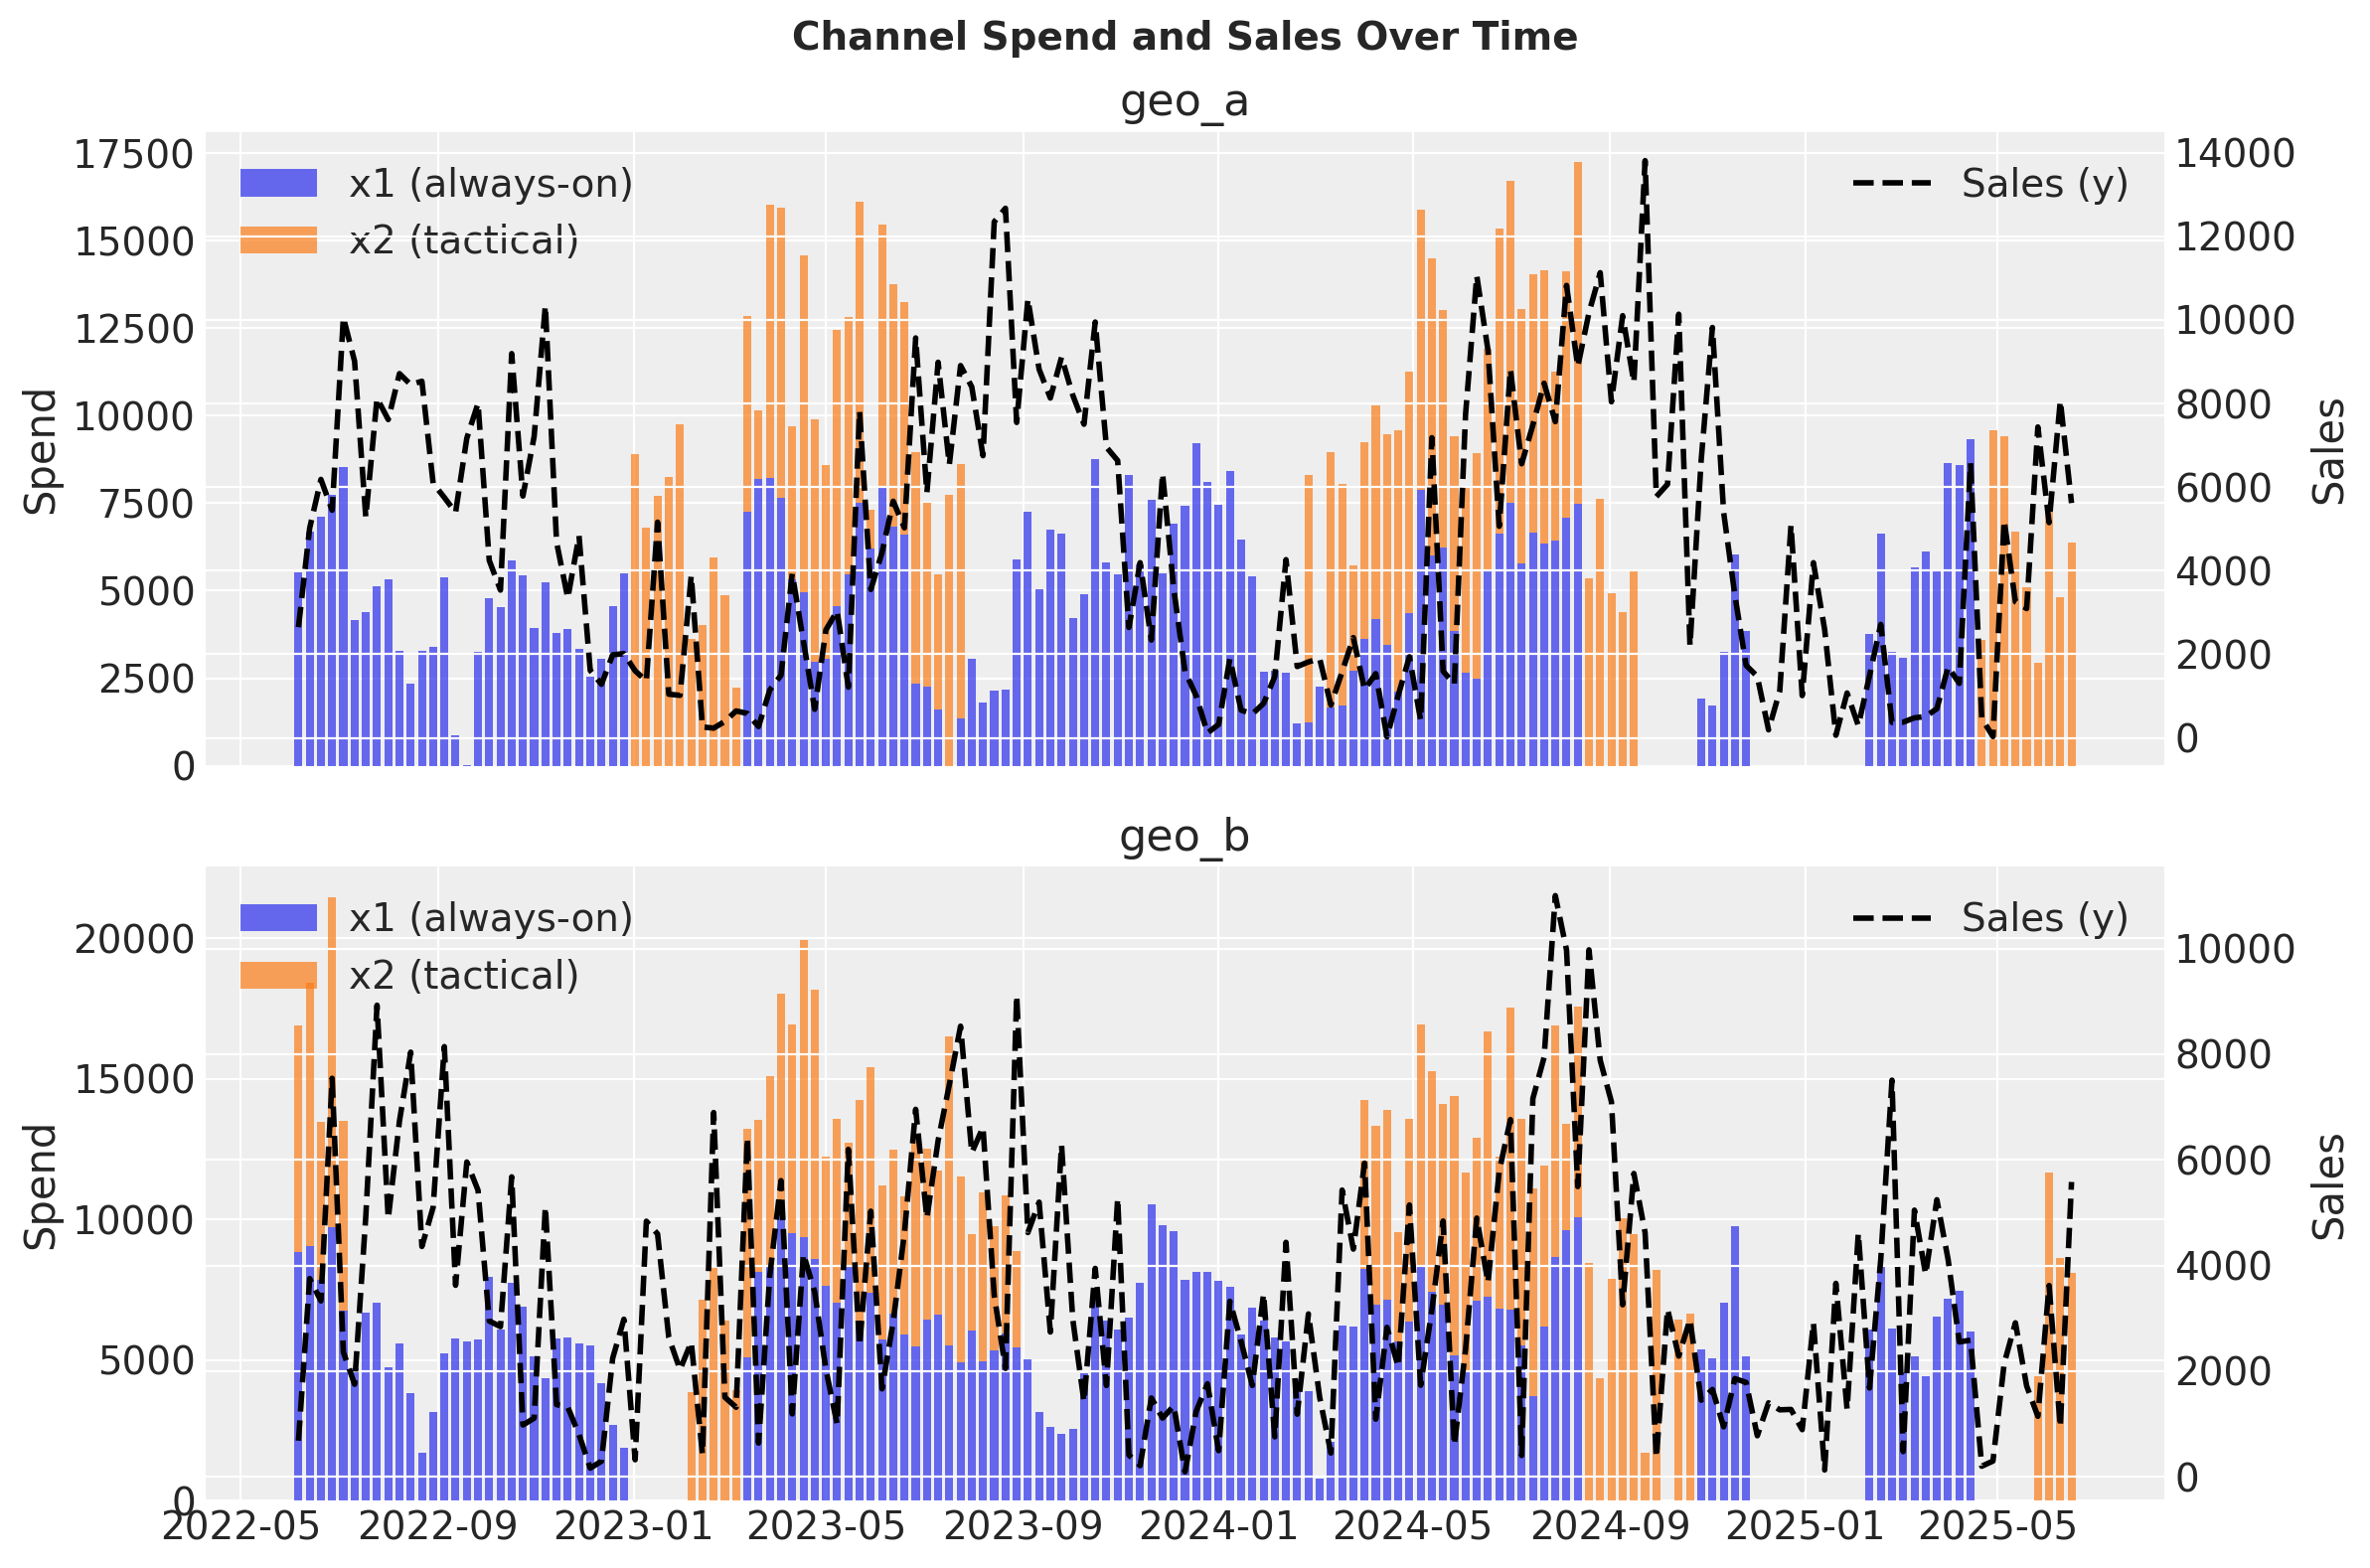

In [3]:
# Quick visualization of spend and sales
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i, geo in enumerate(["geo_a", "geo_b"]):
    ax = axes[i]
    geo_data = data_df[data_df["geo"] == geo]

    ax.bar(geo_data["date"], geo_data["x1"], label="x1 (always-on)", width=5, alpha=0.7)
    ax.bar(
        geo_data["date"],
        geo_data["x2"],
        bottom=geo_data["x1"],
        label="x2 (tactical)",
        width=5,
        alpha=0.7,
    )
    ax2 = ax.twinx()
    ax2.plot(geo_data["date"], geo_data["y"], "k--", label="Sales (y)", linewidth=2)

    ax.set_ylabel("Spend")
    ax2.set_ylabel("Sales")
    ax.set_title(f"{geo}")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

fig.suptitle("Channel Spend and Sales Over Time", fontsize=14, fontweight="bold")
plt.tight_layout()

## Model Specification and Fitting

We'll fit a multi-dimensional MMM with:
- **Geometric Adstock**: Models the carry-over effect of advertising
- **Logistic Saturation**: Models diminishing returns as spend increases

For simplicity, we use a streamlined model configuration.

In [4]:
# Define adstock and saturation transformations
adstock = GeometricAdstock(
    priors={"alpha": Prior("Beta", alpha=2, beta=5, dims=("geo", "channel"))}, l_max=8
)

saturation = LogisticSaturation(
    priors={
        "beta": Prior("Gamma", mu=0.3, sigma=0.15, dims=("geo", "channel")),
        "lam": Prior("Gamma", mu=0.5, sigma=0.25, dims="channel"),
    }
)

In [5]:
# Model configuration
model_config = {
    "intercept": Prior("Gamma", mu=0.5, sigma=0.25, dims="geo"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.5, dims="control"),
    "likelihood": Prior(
        "TruncatedNormal",
        lower=0,
        sigma=Prior("HalfNormal", sigma=1.5),
        dims=("date", "geo"),
    ),
}

In [6]:
# Create the MMM instance
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2"],
    dims=("geo",),
    scaling={
        "channel": {"method": "max", "dims": ()},
        "target": {"method": "max", "dims": ()},
    },
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=2,
    model_config=model_config,
)

In [7]:
# Prepare training data
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

In [8]:
# Build and fit the model
mmm.build_model(X=x_train, y=y_train)

# Add original scale contribution variables (needed for original_scale=True in plots)
mmm.add_original_scale_contribution_variable(var=["channel_contribution", "y"])

# Fit the model
mmm.fit(
    X=x_train,
    y=y_train,
    chains=4,
    draws=500,
    tune=500,
    target_accept=0.95,
    random_seed=rng,
)

# Sample posterior predictive
mmm.sample_posterior_predictive(
    X=x_train,
    random_seed=rng,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 10MB
Dimensions:           (date: 159, geo: 2, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 1kB 2022-06-06 ... 2025-06-16
  * geo               (geo) <U5 40B 'geo_a' 'geo_b'
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, geo, sample) float64 5MB 0.3958 0.509 ... 0.2273
    y_original_scale  (date, geo, sample) float64 5MB 5.467e+03 ... 2.501e+03
Attributes:
    created_at:                 2026-01-13T14:10:20.919521+00:00
    arviz_version:              0.23.0
    inference_library:          pymc
    inference_library_version:  5.27.0

In [9]:
# Quick check of model diagnostics
print(f"Divergences: {mmm.idata.sample_stats.diverging.sum().values}")

Divergences: 0


## Understanding the Saturation Curve

Before diving into the visualizations, let's understand what a saturation curve represents. The **logistic saturation function** we use in this model is:

$$
f(x) = \beta \cdot \frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}
$$

Where:
- $x$ is the (adstocked) media spend
- $\beta$ is the **saturation ceiling** - the maximum contribution a channel can achieve
- $\lambda$ is the **efficiency parameter** - how quickly the curve approaches saturation

Let's visualize how these parameters affect the saturation curve:

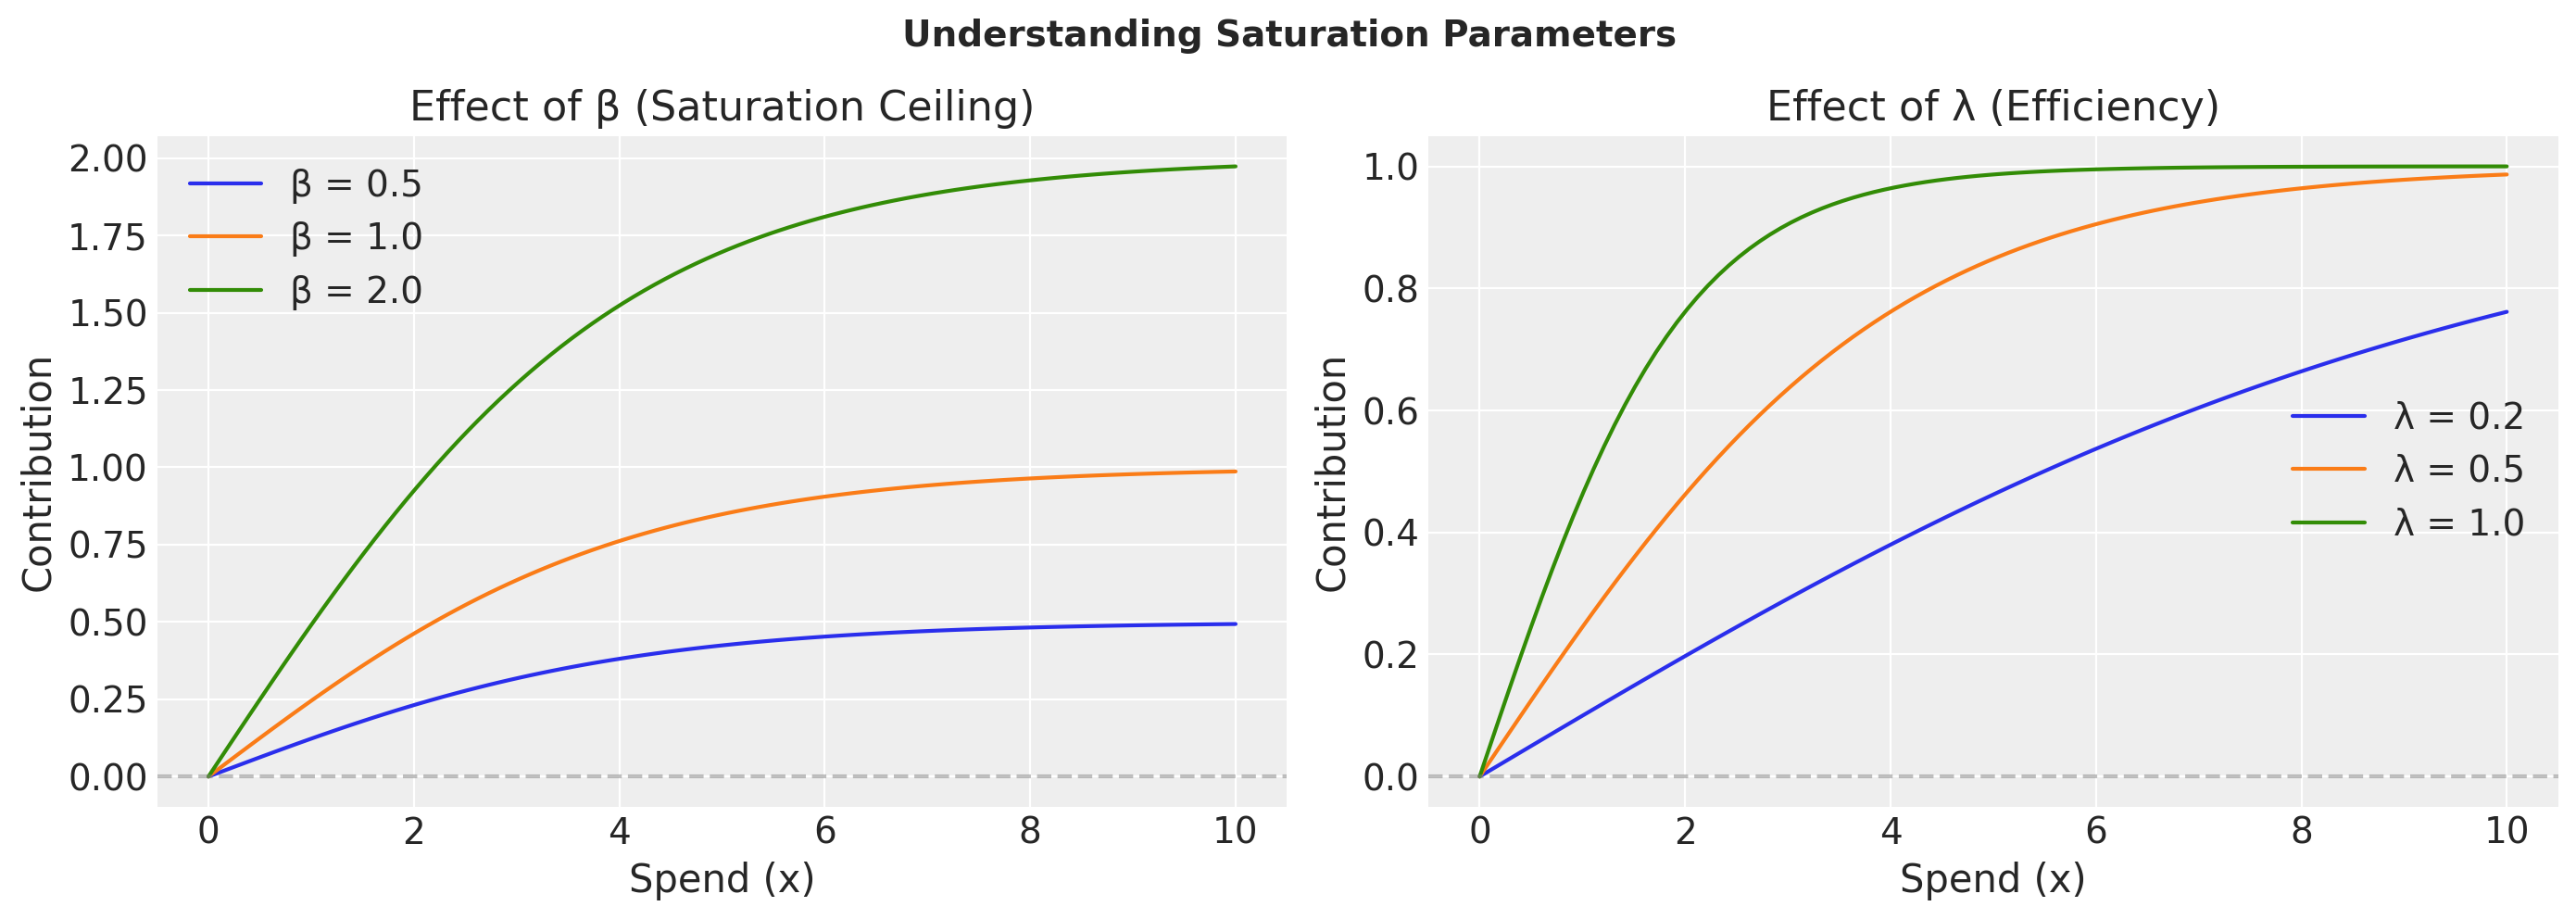

In [10]:
def logistic_saturation(x, beta, lam):
    """Logistic saturation function."""
    return beta * (1 - np.exp(-lam * x)) / (1 + np.exp(-lam * x))


x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Effect of beta (saturation ceiling)
ax = axes[0]
for beta in [0.5, 1.0, 2.0]:
    ax.plot(x, logistic_saturation(x, beta=beta, lam=0.5), label=f"β = {beta}")
ax.set_xlabel("Spend (x)")
ax.set_ylabel("Contribution")
ax.set_title("Effect of β (Saturation Ceiling)")
ax.legend()
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)

# Effect of lambda (efficiency)
ax = axes[1]
for lam in [0.2, 0.5, 1.0]:
    ax.plot(x, logistic_saturation(x, beta=1.0, lam=lam), label=f"λ = {lam}")
ax.set_xlabel("Spend (x)")
ax.set_ylabel("Contribution")
ax.set_title("Effect of λ (Efficiency)")
ax.legend()
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)

fig.suptitle("Understanding Saturation Parameters", fontsize=14, fontweight="bold")
plt.tight_layout()

**Key observations:**
- Higher $\beta$ → Higher maximum contribution (the curve's ceiling)
- Higher $\lambda$ → Faster saturation (the curve rises more steeply but plateaus sooner)

Now let's see how these concepts manifest in our fitted model through two different visualizations.

---

## Visualization 1: Direct/Marginal Contribution (`saturation_scatterplot`)

The `saturation_scatterplot` shows the **direct relationship between spend and contribution at each time point**. This visualization answers the question:

> *"Given a specific spend level, what is the direct contribution to sales?"*

Each point in this plot represents a single observation (one time period), showing:
- **X-axis**: Channel spend at that time point
- **Y-axis**: Direct contribution to sales at that time point

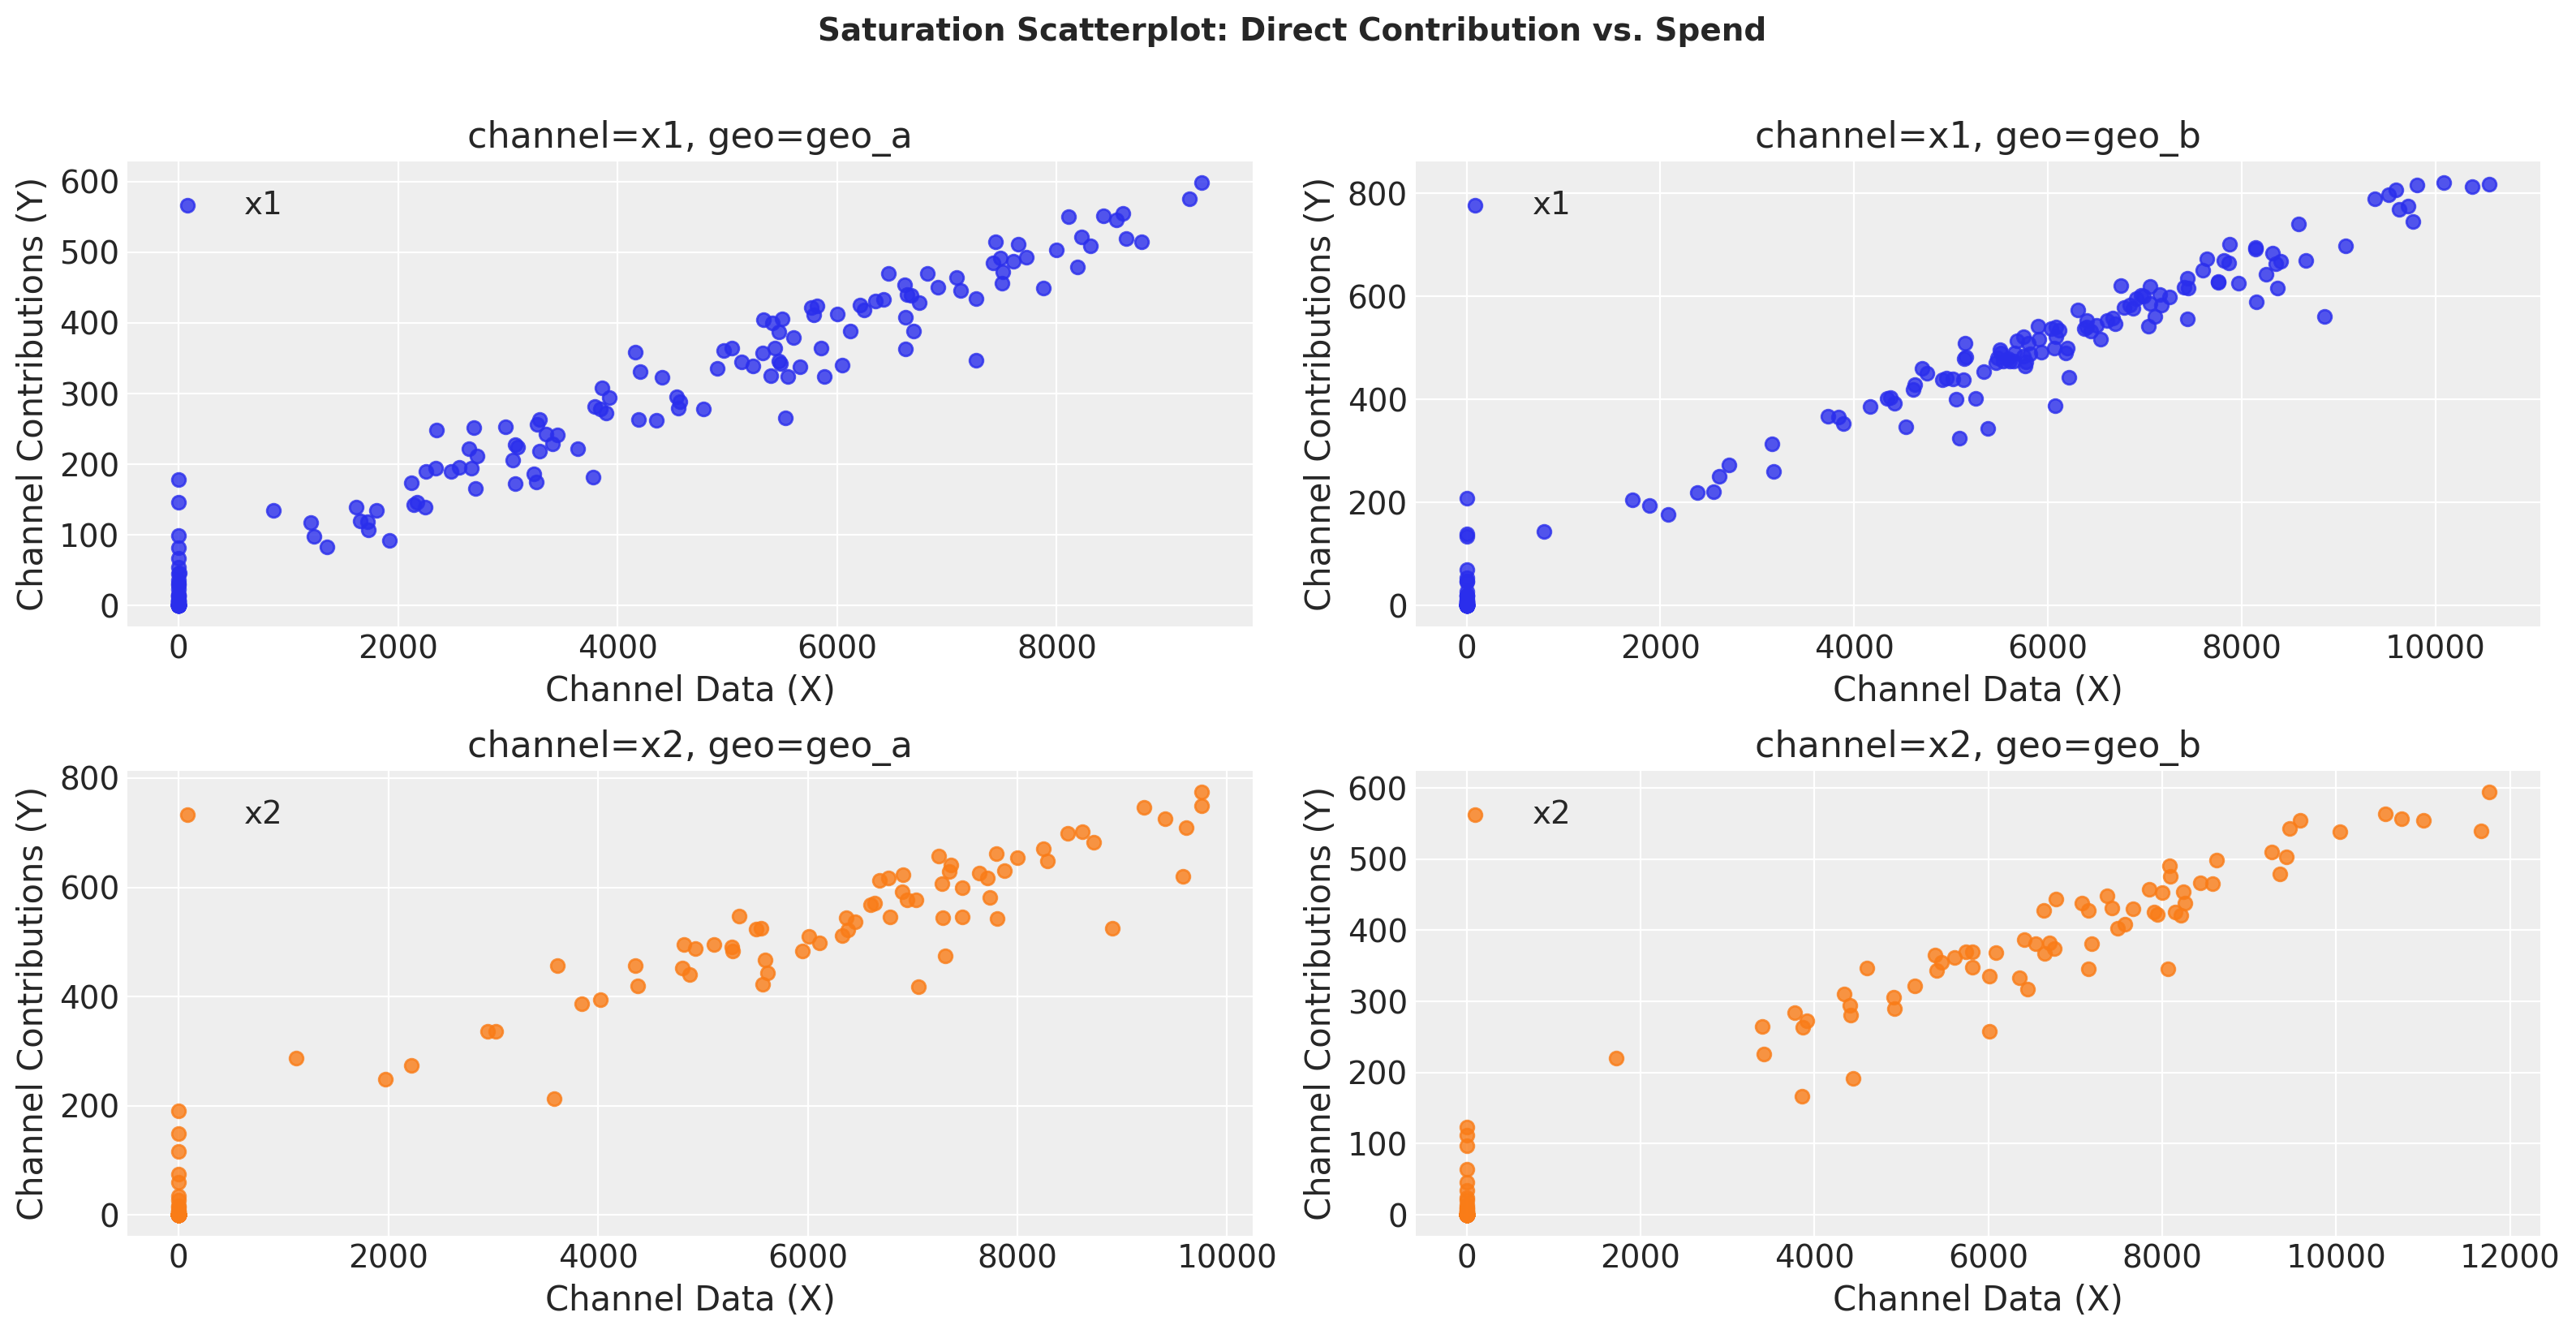

In [11]:
fig, axes = mmm.plot.saturation_scatterplot(
    width_per_col=8,
    height_per_row=4,
    original_scale=True,
)
fig.suptitle(
    "Saturation Scatterplot: Direct Contribution vs. Spend",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()

**How to interpret this plot:**

1. **Shape of the curve**: The fitted line shows how contribution increases with spend, with diminishing returns visible as the curve flattens at higher spend levels.

2. **Scatter points**: Each point represents a specific date's spend-contribution pair. Points above/below the curve indicate dates where contribution was higher/lower than the model's average prediction.

3. **HDI bands**: The shaded region represents the 94% Highest Density Interval, showing uncertainty in the saturation curve.

4. **Subplots by geography**: Each row shows results for a different geography, allowing you to compare saturation patterns across markets.

```{note}
This plot shows the **instantaneous/marginal** relationship. It tells you "if I spend X on a given day, I expect Y contribution on that day."
```

---

## Visualization 2: Total Contribution over Spend Share (`plot_channel_contribution_grid`)

The `plot_channel_contribution_grid` shows how **total contribution (summed over all time periods)** changes as you scale overall spend. This visualization answers the question:

> *"If I increase/decrease my total budget by X%, what is the total impact on sales?"*

This is a **counterfactual analysis**: we ask "what would have happened if we had spent more or less?"

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


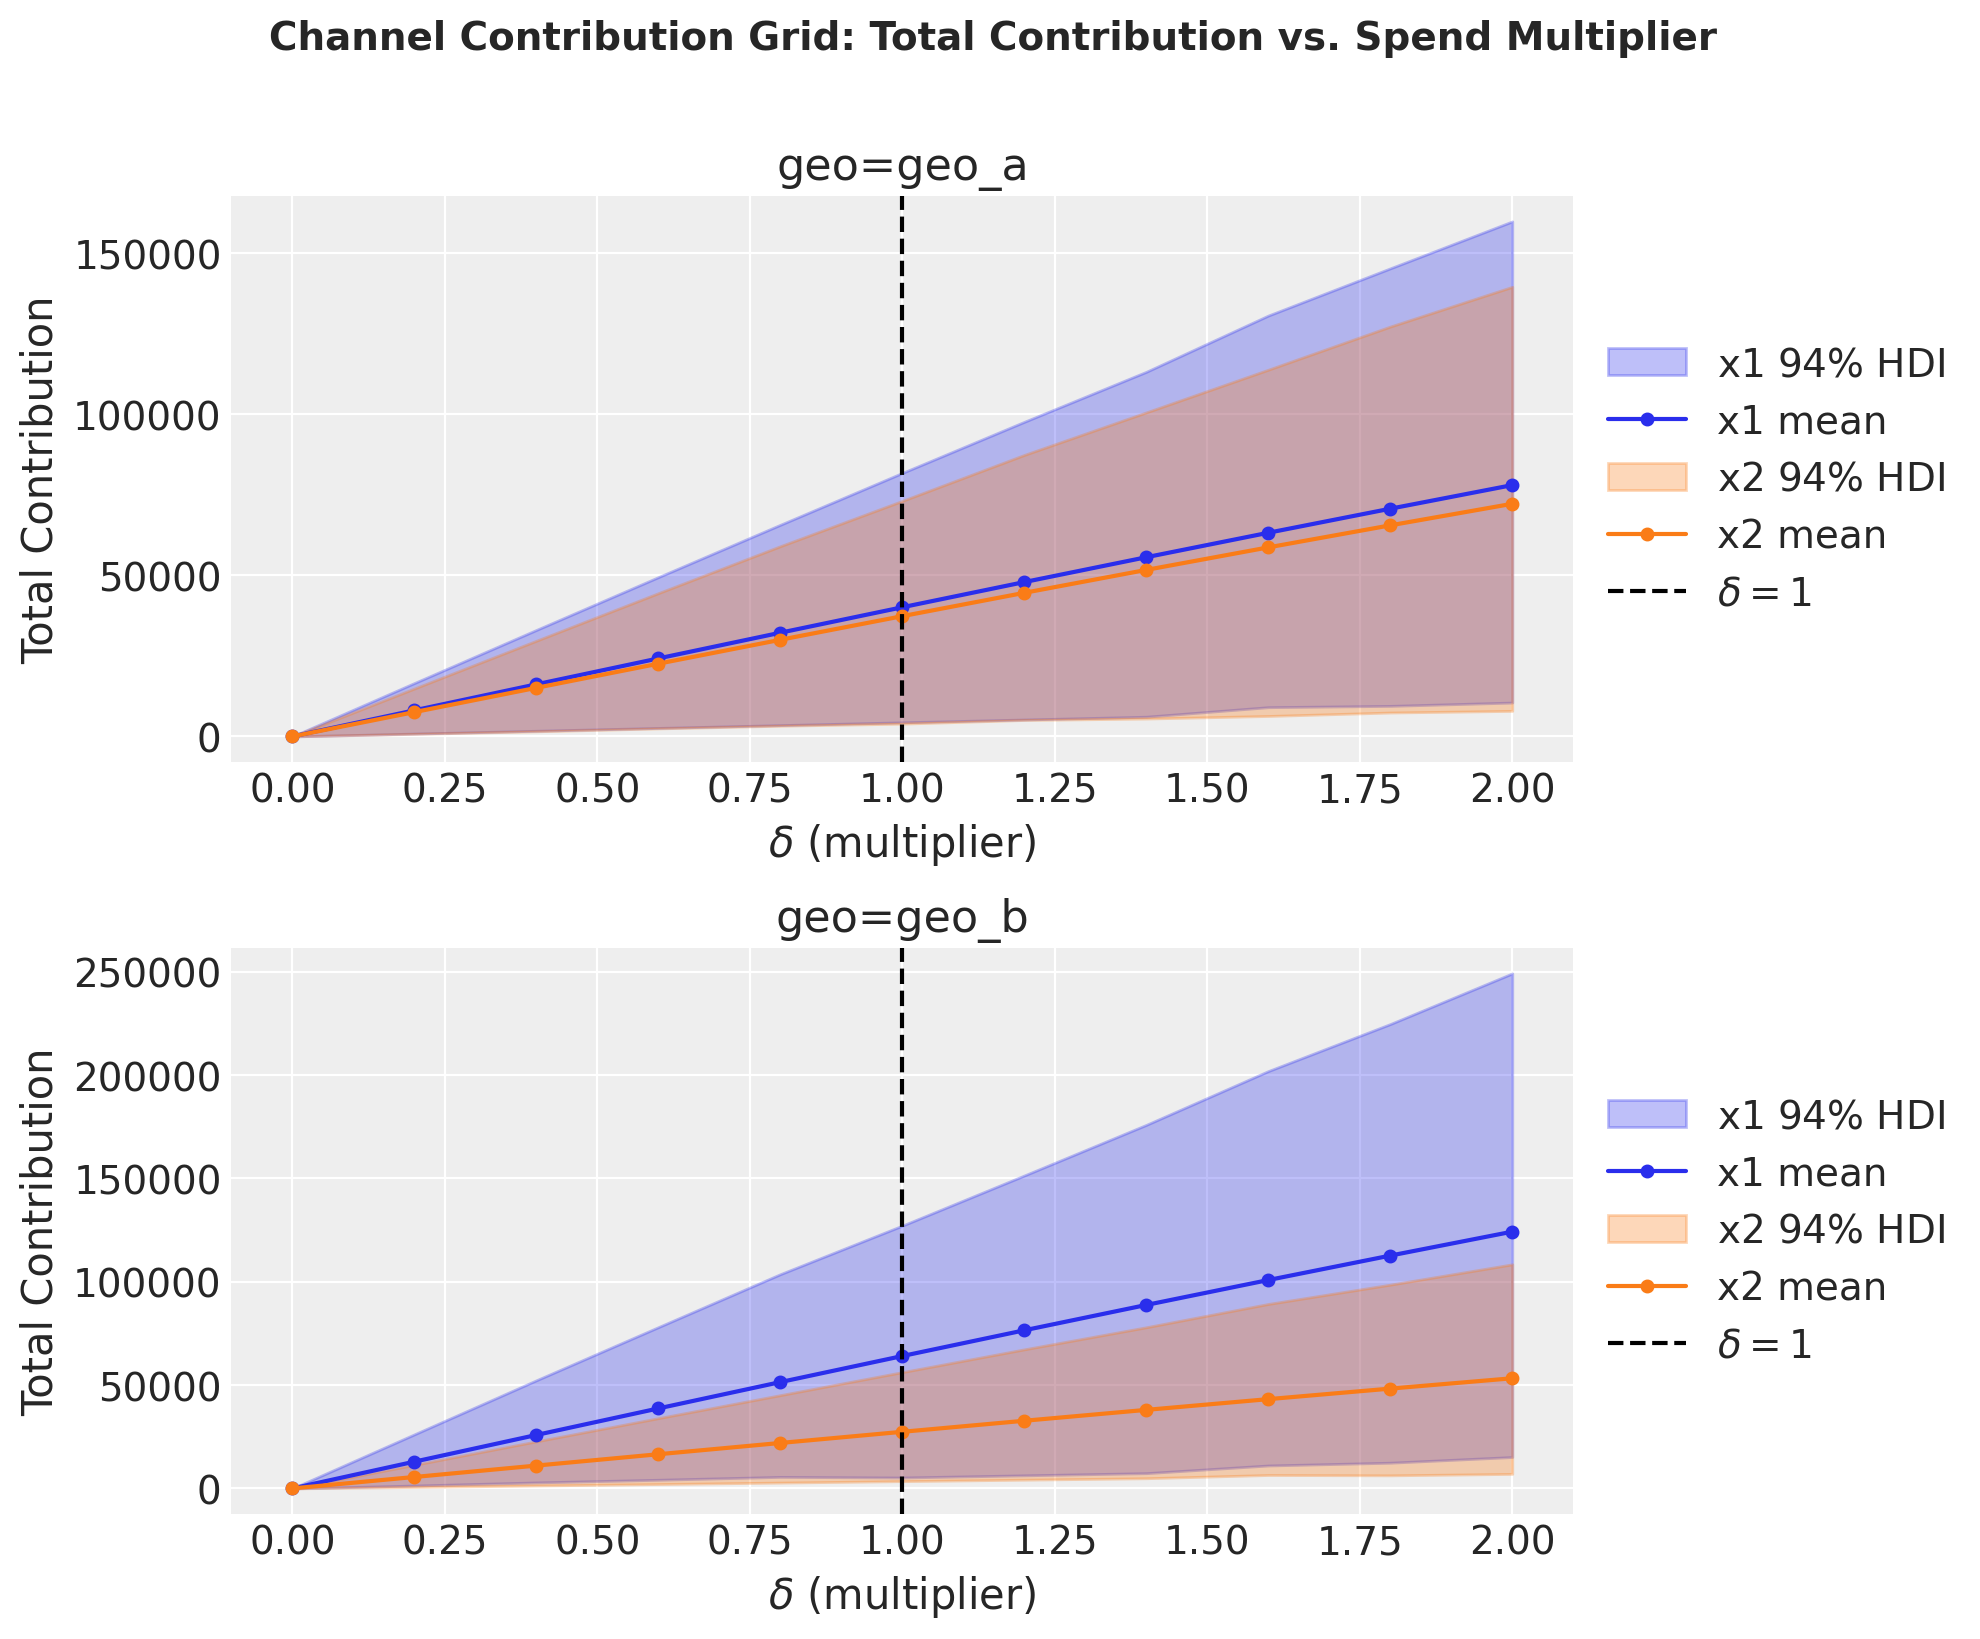

In [12]:
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid: Total Contribution vs. Spend Multiplier",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()

**How to interpret this plot:**

1. **X-axis (δ - delta)**: The spend multiplier. A value of 1.0 represents the actual historical spend, 0.5 means half the spend, and 2.0 means double the spend.

2. **Y-axis (Total Contribution)**: The sum of contributions across all time periods in the dataset.

3. **Vertical line at δ=1**: This marks the current/historical spend level.

4. **HDI bands**: Show the uncertainty in total contribution at each spend level.

5. **Curve shape**: 
   - Steep slope at low δ → High marginal returns (you're not yet saturated)
   - Flattening slope at high δ → Diminishing returns (approaching saturation)

```{important}
This plot shows the **global/total** relationship. It tells you "across the entire time period, if I had scaled all my spend by factor δ, my total contribution would be Y."
```

---

## Comparing the Two Visualizations

Now let's put both visualizations side by side to understand their differences clearly.

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


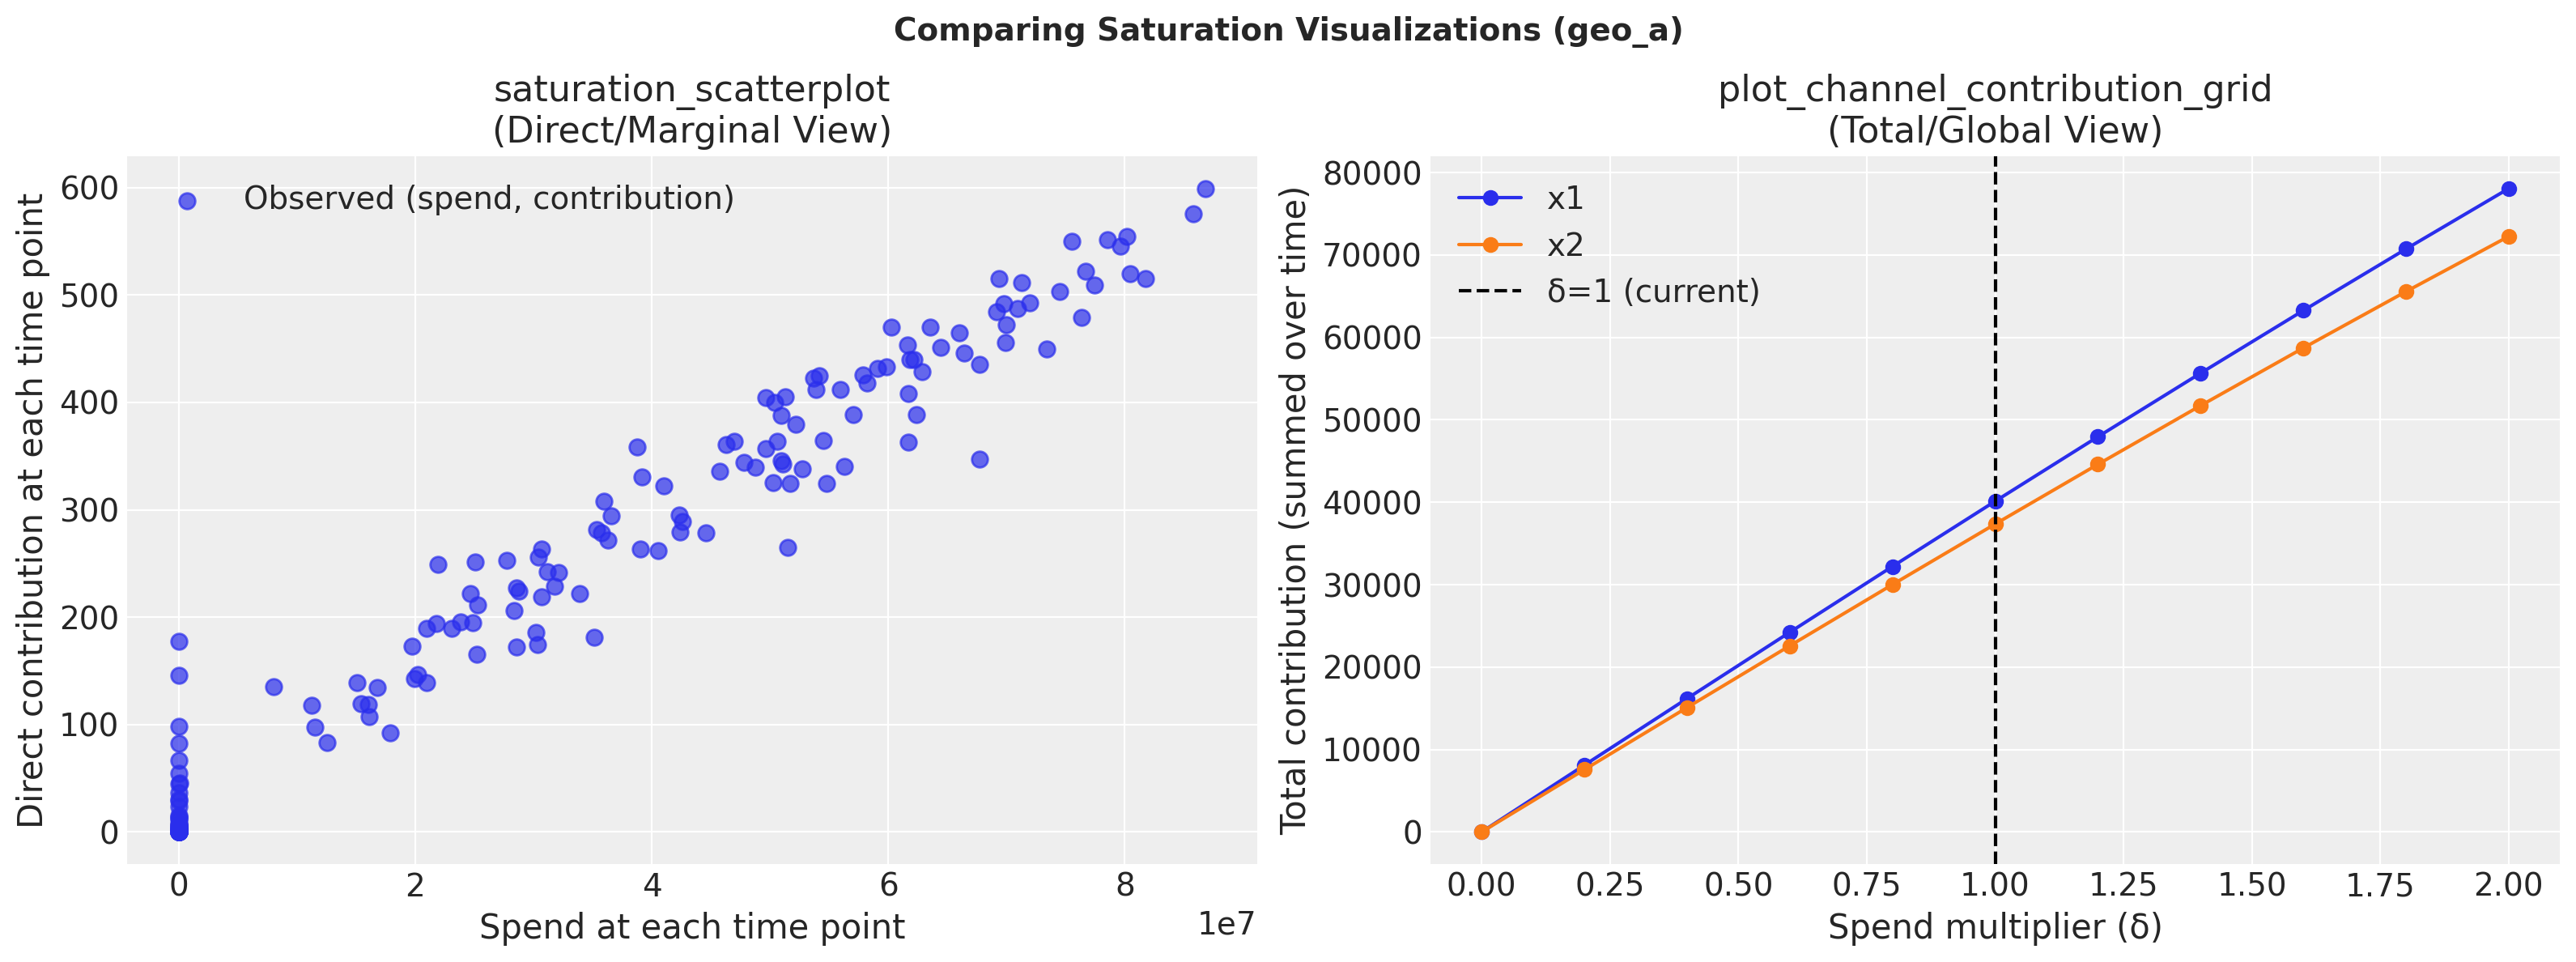

In [13]:
fig = plt.figure(figsize=(16, 6))

# Left: Saturation scatterplot (simplified view for one geo)
ax1 = fig.add_subplot(1, 2, 1)

# Get saturation data for geo_a, channel x1
channel_data = mmm.idata.constant_data.channel_data.sel(geo="geo_a", channel="x1")
channel_contribution = mmm.idata.posterior.channel_contribution.sel(
    geo="geo_a", channel="x1"
)

# Scale to original scale - handle both scalar and per-geo scales
target_scale = mmm.scalers._target
if target_scale.dims:
    # Per-geo scale: select geo_a
    target_scale_val = float(target_scale.sel(geo="geo_a").values)
else:
    target_scale_val = float(target_scale.values)

channel_scale_da = mmm.scalers._channel.sel(channel="x1")
if "geo" in channel_scale_da.dims:
    channel_scale = float(channel_scale_da.sel(geo="geo_a").values)
else:
    channel_scale = float(channel_scale_da.values)

x_vals = channel_data.values * channel_scale
y_mean = channel_contribution.mean(dim=("chain", "draw")).values * target_scale_val

ax1.scatter(x_vals, y_mean, alpha=0.7, s=50, label="Observed (spend, contribution)")
ax1.set_xlabel("Spend at each time point")
ax1.set_ylabel("Direct contribution at each time point")
ax1.set_title("saturation_scatterplot\n(Direct/Marginal View)")
ax1.legend()

# Right: Contribution grid (simplified view for one geo)
ax2 = fig.add_subplot(1, 2, 2)

# Get grid data
grid_data = mmm.get_channel_contribution_forward_pass_grid(start=0.0, stop=2.0, num=11)
grid_geo_a = grid_data.sel(geo="geo_a")

delta_vals = grid_geo_a.coords["delta"].values

for i, channel in enumerate(["x1", "x2"]):
    total_contrib = grid_geo_a.sel(channel=channel).sum(dim="date")
    mean_contrib = total_contrib.mean(dim=("chain", "draw")).values
    ax2.plot(delta_vals, mean_contrib, "o-", label=channel, color=f"C{i}")

ax2.axvline(x=1.0, color="black", linestyle="--", label="δ=1 (current)")
ax2.set_xlabel("Spend multiplier (δ)")
ax2.set_ylabel("Total contribution (summed over time)")
ax2.set_title("plot_channel_contribution_grid\n(Total/Global View)")
ax2.legend()

fig.suptitle(
    "Comparing Saturation Visualizations (geo_a)", fontsize=14, fontweight="bold"
)
plt.tight_layout()

### Summary of Differences

| Aspect | `saturation_scatterplot` | `plot_channel_contribution_grid` |
|--------|--------------------------|----------------------------------|
| **X-axis** | Spend at each time point | Spend multiplier or total spend |
| **Y-axis** | Direct contribution per time point | Total contribution summed over time |
| **Each point represents** | One observation (date) | One counterfactual scenario |
| **Question answered** | What is the marginal contribution at each spend level? | What happens to total impact if I change budget? |
| **Primary use case** | Understanding saturation curve shape | Budget planning and what-if analysis |
| **Aggregation** | None (shows individual observations) | Sums contribution over all dates |

```{warning}
**Common confusion**: Users often expect `saturation_scatterplot` to show total contributions, leading to misinterpretation. Remember:
- `saturation_scatterplot` = **Point-in-time** relationship
- `plot_channel_contribution_grid` = **Cumulative** relationship across all time
```

---

## Advanced Usage of `plot_channel_contribution_grid`

The `plot_channel_contribution_grid` method supports several advanced options for customization.

### Using Absolute X-Range

Instead of showing the multiplier, you can display absolute spend values on the x-axis using `absolute_xrange=True`:

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


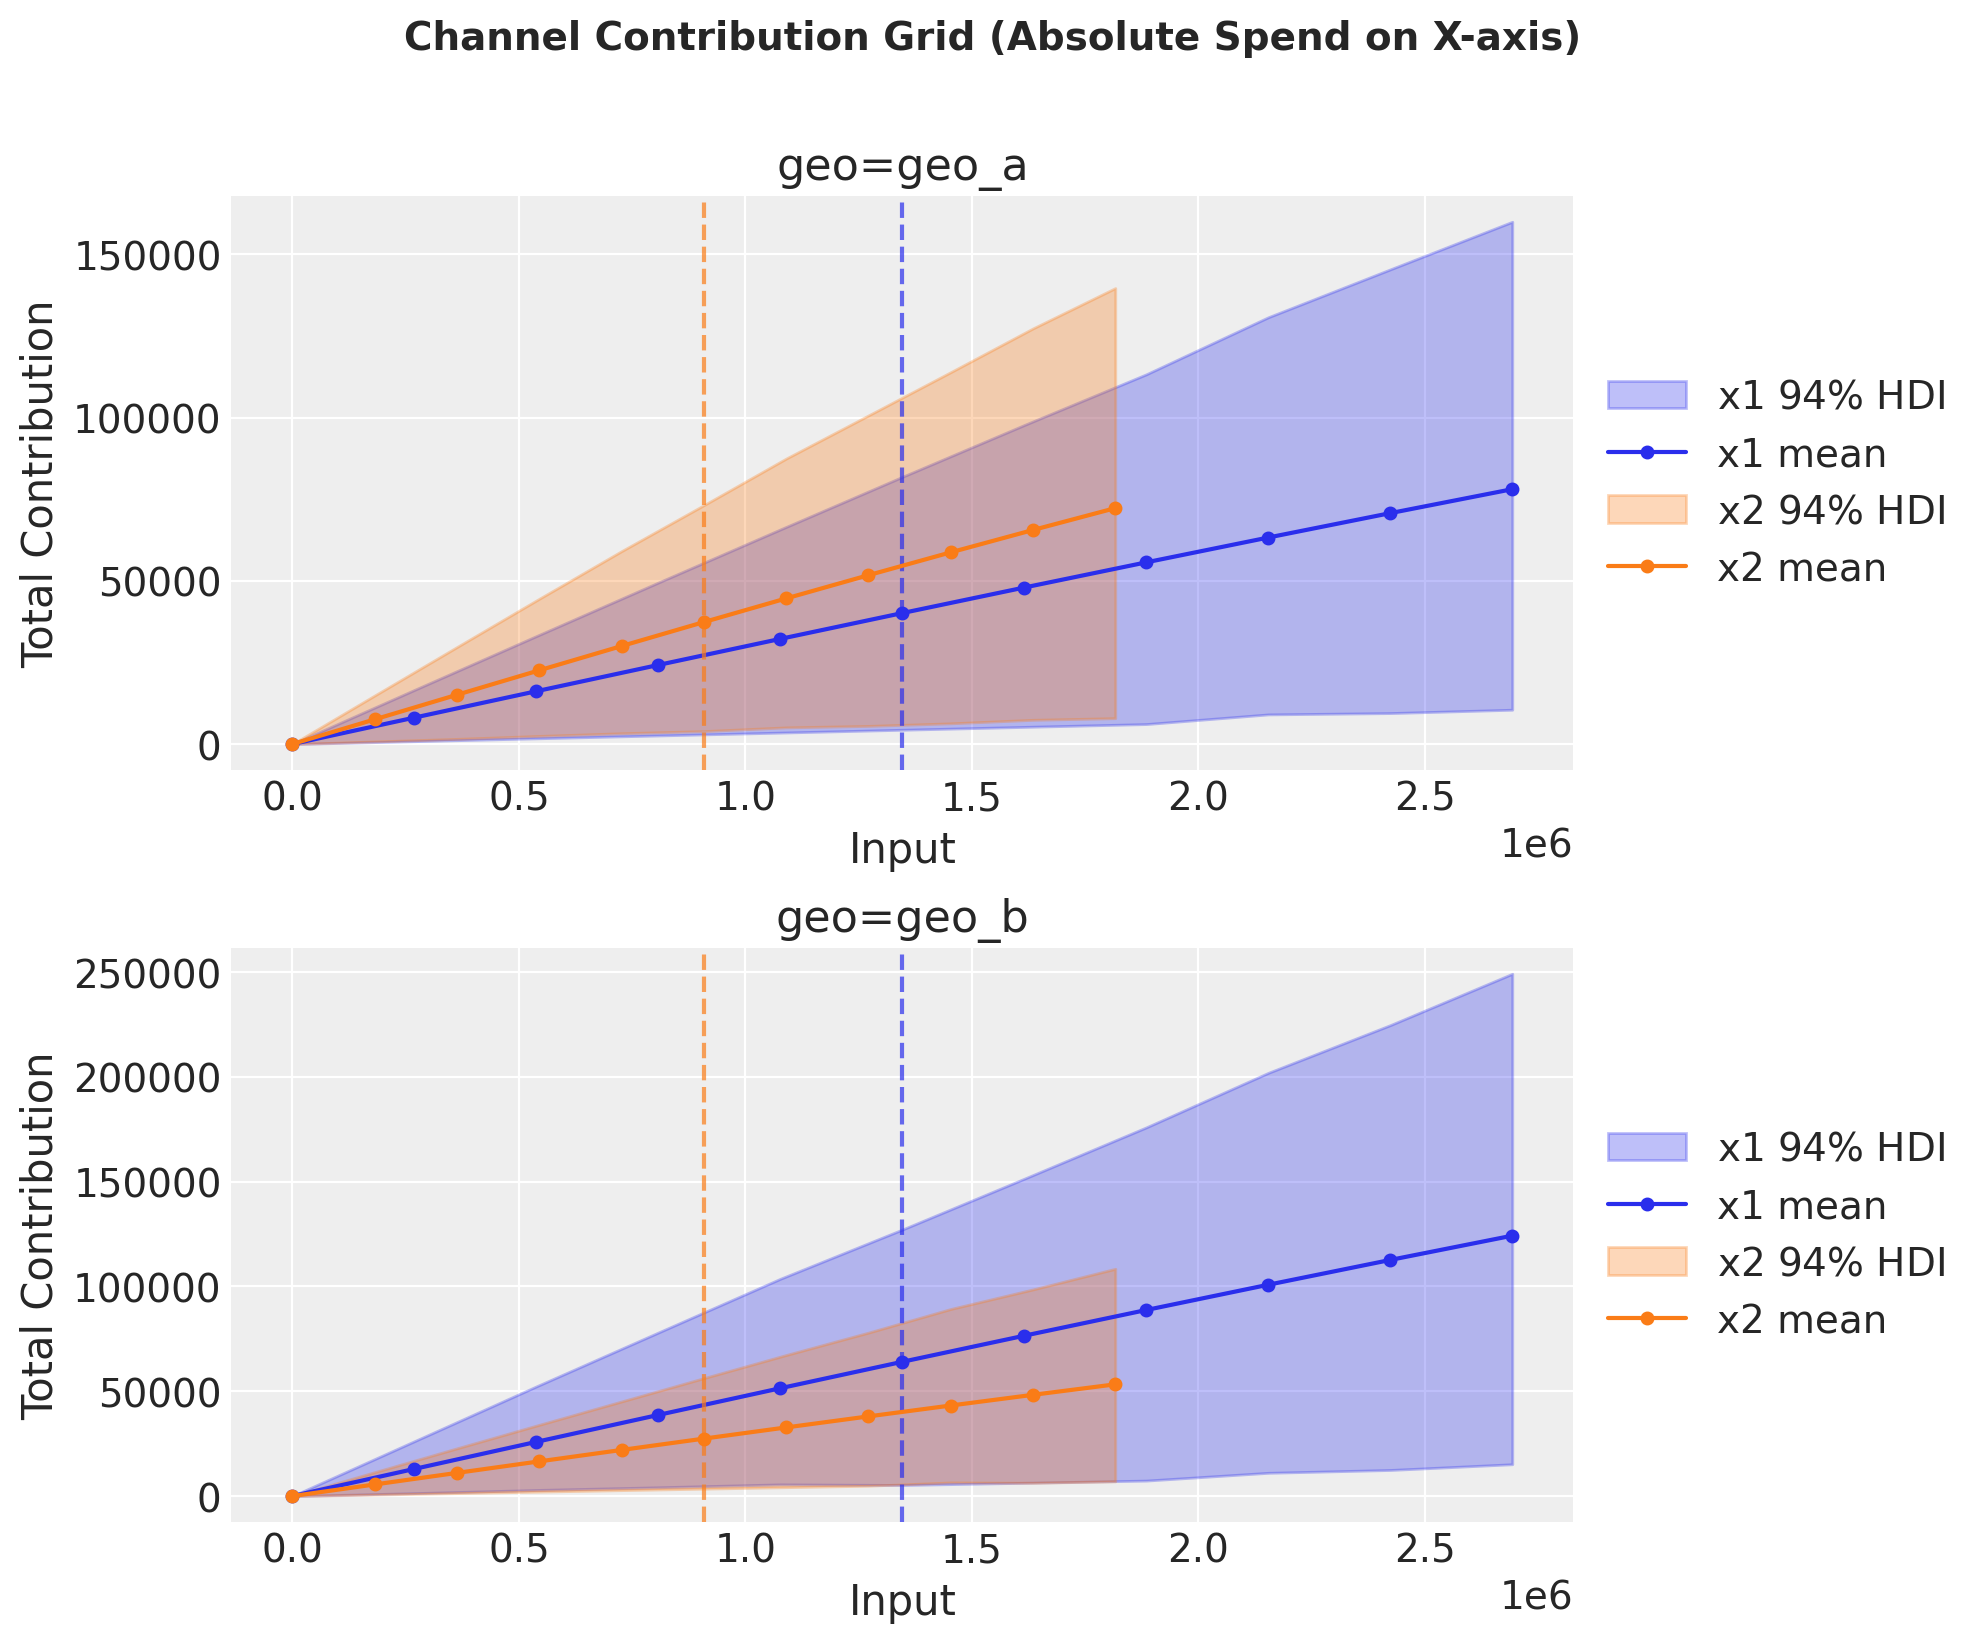

In [14]:
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    absolute_xrange=True,  # Show absolute spend on x-axis
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid (Absolute Spend on X-axis)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()

With `absolute_xrange=True`:
- The x-axis shows actual spend values (total spend across all dates)
- Vertical dashed lines indicate the current total spend for each channel
- This view is more intuitive for budget discussions ("If we spend X total, we get Y contribution")

### Filtering by Geography

 Use the `dims` parameter to focus on specific geographies:

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


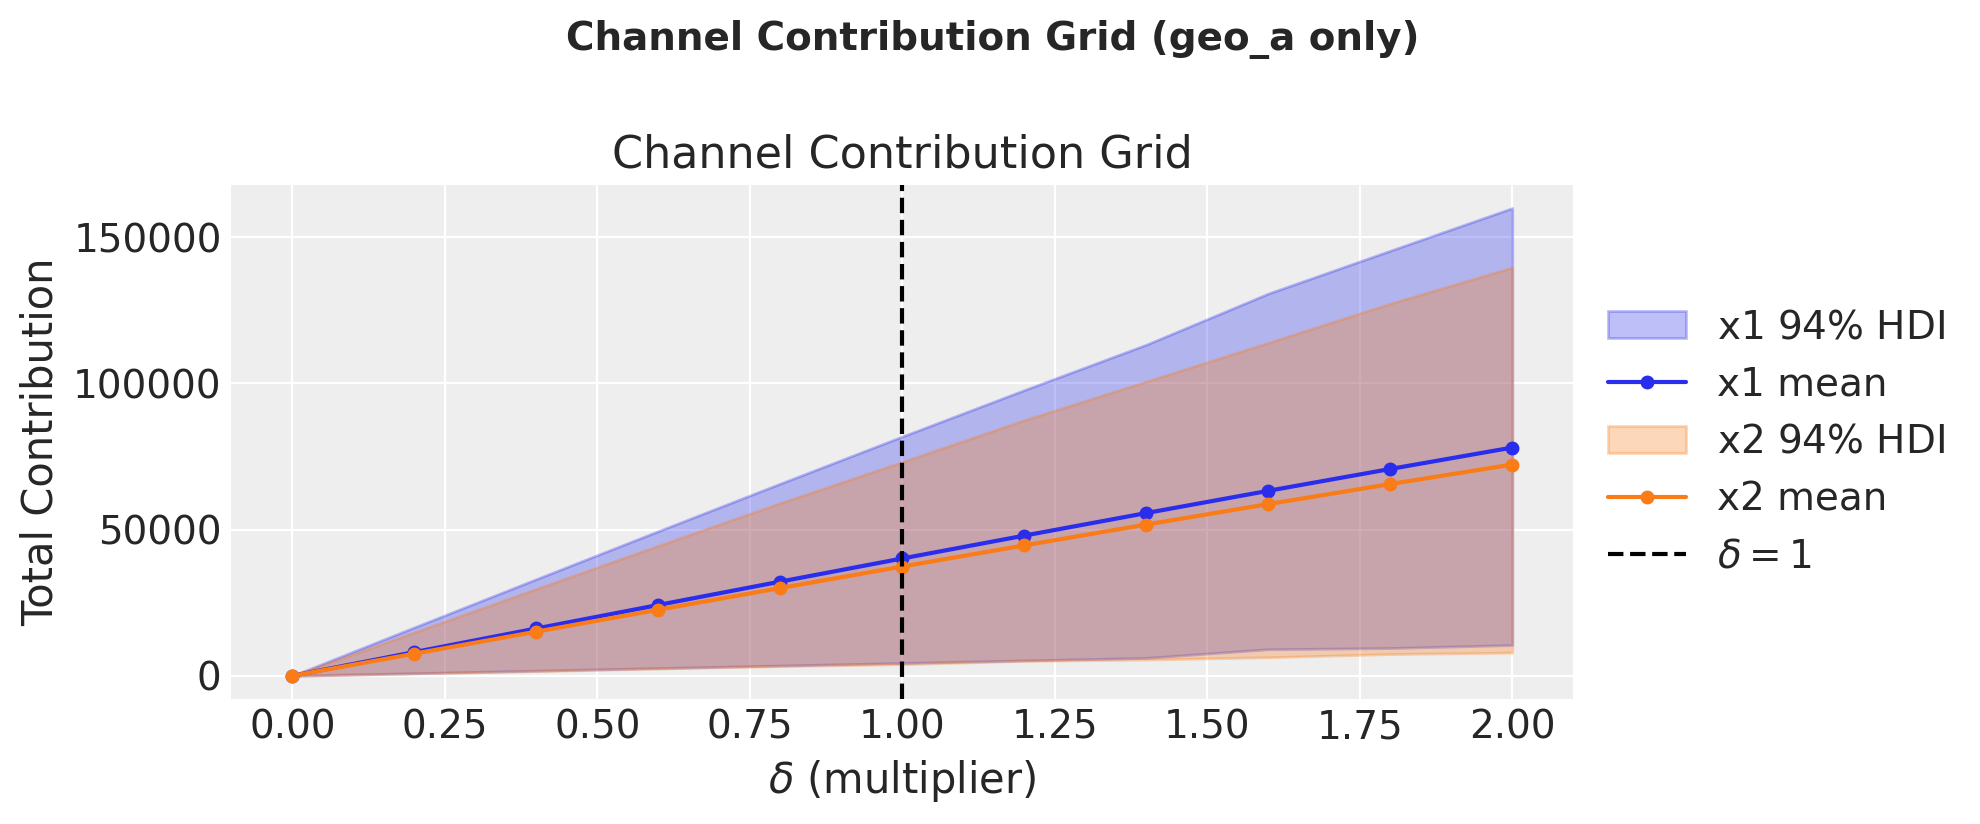

In [15]:
# Filter to show only geo_a
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    dims={"geo": "geo_a"},  # Filter to single geography
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid (geo_a only)", fontsize=14, fontweight="bold", y=1.02
)
plt.tight_layout()

### Aggregating Across Geographies

Use the `aggregation` parameter to combine results across dimensions. This is useful when you want to see the total impact across all markets:

Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


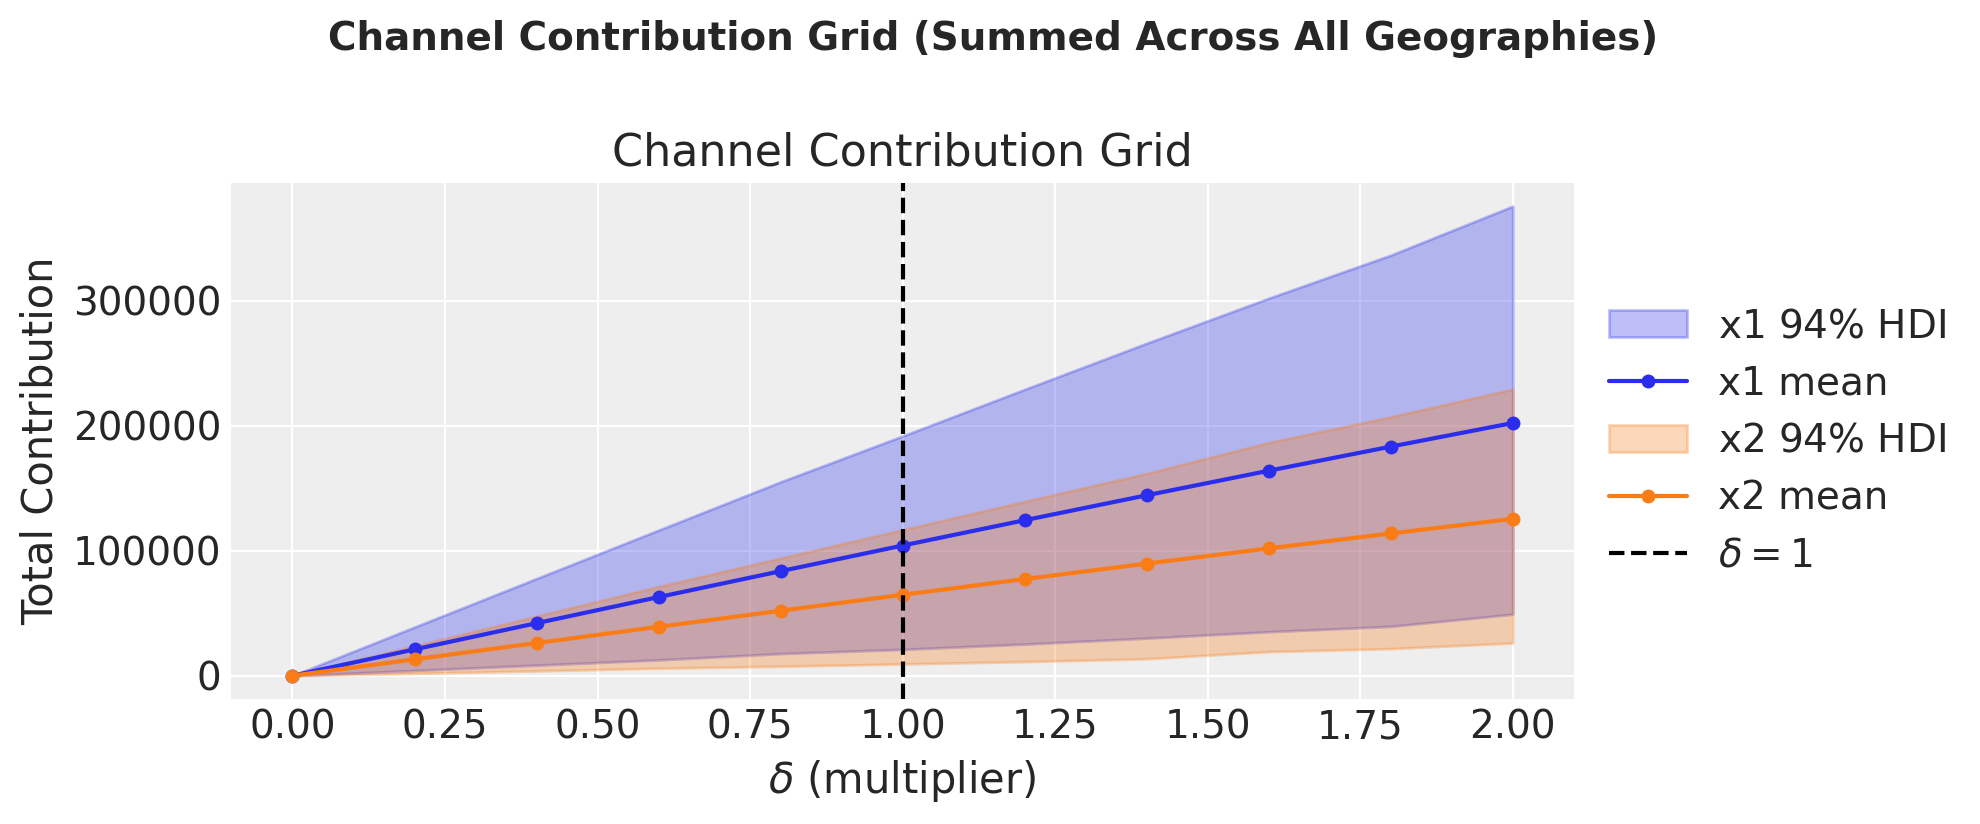

In [16]:
# Aggregate (sum) contributions across all geographies
fig, axes = mmm.plot_channel_contribution_grid(
    start=0.0,
    stop=2.0,
    num=11,
    aggregation={"sum": ("geo",)},  # Sum over geo dimension
    hdi_prob=0.94,
)
fig.suptitle(
    "Channel Contribution Grid (Summed Across All Geographies)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()

Supported aggregation operations:
- `"sum"`: Sum contributions across the specified dimensions
- `"mean"`: Average contributions across the specified dimensions
- `"median"`: Median contributions across the specified dimensions

---

## Summary

In this tutorial, we explored two complementary ways to visualize media saturation in Marketing Mix Models:

1. **`saturation_scatterplot`**: Shows the direct/marginal relationship between spend and contribution at each time point. Best for understanding the shape of saturation and validating model behavior.

2. **`plot_channel_contribution_grid`**: Shows how total contribution changes as you scale overall spend. Best for budget planning, what-if analysis, and making allocation decisions.

Understanding the difference between these visualizations is crucial for correctly interpreting your MMM results and making informed marketing decisions.

```{seealso}
- {ref}`mmm_example` - Basic MMM tutorial
- {ref}`mmm_multidimensional_example` - Multi-dimensional MMM tutorial
- {ref}`mmm_budget_allocation_example` - Budget optimization tutorial
```

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Tue, 13 Jan 2026

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.9.0

pymc    : 5.27.0
pytensor: 2.36.3

arviz         : 0.23.0
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
pymc_extras   : 0.7.0
pymc_marketing: 0.17.1

Watermark: 2.6.0

